In [3]:
import requests
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopandas as gpd
import contextily as ctx

In [4]:
cities = [
    ["Delhi", "India"],
    ["Mumbai", "India"],
    ["Kolkata", "India"],
    ["Chennai", "India"],
    ["Bengaluru", "India"],
    ["Hyderabad", "India"],
    ["Ahmedabad", "India"],
    ["Surat", "India"],
    ["Pune", "India"],
    ["Jaipur", "India"]
]

In [5]:
df = pd.DataFrame(cities, columns=["city", "country"])

In [6]:
# Criando um localizador (geocoder) usando Nominatim com um identificador de usuário personalizado
locator = Nominatim(user_agent="myGeocoder")

# Criando um limitador de taxa para evitar solicitações muito rápidas ao serviço de geocodificação
geocode = RateLimiter(locator.geocode, min_delay_seconds=.1)

# Função para obter as coordenadas (latitude e longitude) de uma cidade e país
def get_coordinates(city, country):
    # Realizando a consulta de geocodificação usando o limitador de taxa
    response = geocode(query={"city": city, "country": country})
    
    # Retornando as coordenadas em um formato de dicionário
    return {
        "latitude": response.latitude,
        "longitude": response.longitude
    }

# Aplicando a função get_coordinates a cada linha do DataFrame df e armazenando os resultados em df_coordinates
df_coordinates = df.apply(lambda x: get_coordinates(x.city, x.country), axis=1)

# Concatenando as novas colunas de coordenadas ao DataFrame original df
df = pd.concat([df, pd.json_normalize(df_coordinates)], axis=1)

In [7]:
df.head()

,city,country,latitude,longitude
0,Delhi,India,24.639961,81.573790
1,Mumbai,India,19.081577,72.886628
2,Kolkata,India,22.572646,88.363895
3,Chennai,India,13.083694,80.270186
4,Bengaluru,India,12.976794,77.590082


In [8]:
import datetime

# Função para obter dados meteorológicos para uma determinada cidade usando a API OpenWeatherMap
def get_weather(row):
    # Construindo a URL da API com as coordenadas da cidade e a chave da API
    api = f"https://api.openweathermap.org/data/2.5/weather?lat={row.latitude}&lon={row.longitude}&appid={'04ce841543d5e71d6ccfa4ae2313f841'}"
    
    # Fazendo uma solicitação à API OpenWeatherMap
    response = requests.get(api)
    
    # Convertendo a resposta para JSON
    response_json = response.json()
    
    # Convertendo o timestamp do pôr do sol de UTC para o formato de data e hora local
    sunset_utc = datetime.datetime.fromtimestamp(response_json["sys"]["sunset"])
    
    # Retornando um dicionário com os dados meteorológicos desejados
    return {
        "temp": response_json["main"]["temp"] - 273.15,  # Convertendo de Kelvin para Celsius
        "description": response_json["weather"][0]["description"],
        "icon": response_json["weather"][0]["icon"],
        "sunset_utc": sunset_utc,
        "sunset_local": sunset_utc + datetime.timedelta(seconds=response_json["timezone"])
    }

# Aplicando a função get_weather a cada linha do DataFrame df e armazenando os resultados em df_weather
df_weather = df.apply(lambda x: get_weather(x), axis=1)

# Concatenando as novas colunas de dados meteorológicos ao DataFrame original df
df = pd.concat([df, pd.json_normalize(df_weather)], axis=1)


In [9]:
df.head()

,city,country,latitude,longitude,temp,description,icon,sunset_utc,sunset_local
0,Delhi,India,24.639961,81.573790,19.29,broken clouds,04n,2023-11-14 08:47:34,2023-11-14 14:17:34
1,Mumbai,India,19.081577,72.886628,27.97,haze,50n,2023-11-14 09:30:39,2023-11-14 15:00:39
2,Kolkata,India,22.572646,88.363895,21.96,haze,50n,2023-11-14 08:23:35,2023-11-14 13:53:35
3,Chennai,India,13.083694,80.270186,25.56,moderate rain,10n,2023-11-14 09:09:32,2023-11-14 14:39:32
4,Bengaluru,India,12.976794,77.590082,18.90,broken clouds,04n,2023-11-14 09:20:24,2023-11-14 14:50:24


In [10]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs=4326)

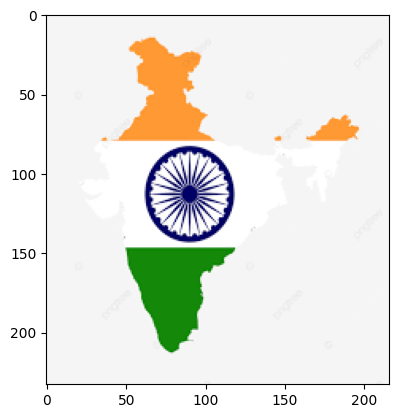

In [12]:
import matplotlib.pyplot as plt
img = plt.imread("C:\\Users\\Rodrigo\\Documents\\PROJETOS\\INTELI\\MÓDULO 8\\ATIVIDADE_PROGRAMACAO_ETL\\img\\download.png")
plt.imshow(img)
plt.show()

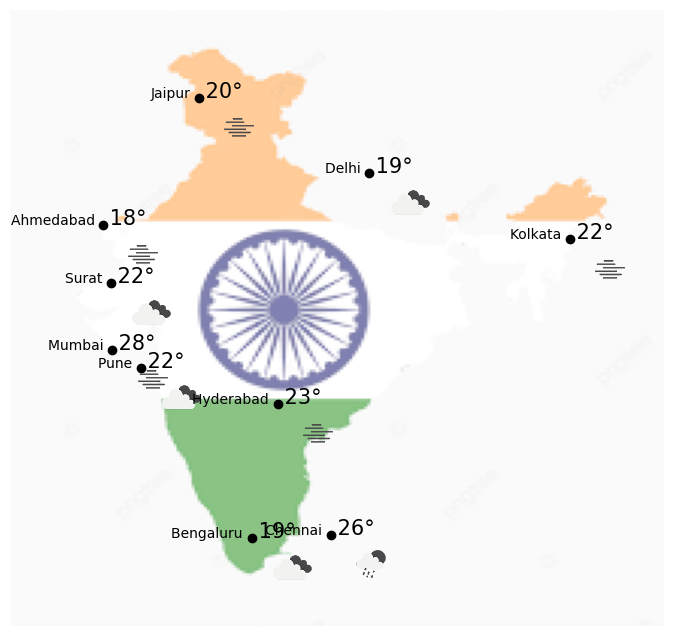

In [13]:
from skimage import io
from matplotlib.offsetbox import AnnotationBbox, OffsetImage  
from PIL import Image

# Ponto da cidade
ax = gdf.to_crs(epsg=3857).plot(figsize=(12,8), color="black")

# Icone de clima
def add_icon(row):
  img = io.imread(f"https://openweathermap.org/img/wn/{row.icon}@2x.png")
  img_offset = OffsetImage(img, zoom=.4, alpha=1, )
  ab = AnnotationBbox(img_offset, [row.geometry.x+150000, row.geometry.y-110000], frameon=False)
  ax.add_artist(ab)

gdf.to_crs(epsg=3857).apply(add_icon, axis=1)

# nome da cidade
gdf.to_crs(epsg=3857).apply(lambda x: ax.annotate(text=f"{x.city}  ", fontsize=10, color="black", xy=x.geometry.centroid.coords[0], ha='right'), axis=1);

# temperatura da cidade
gdf.to_crs(epsg=3857).apply(lambda x: ax.annotate(text=f" {round(x.temp)}°", fontsize=15, color="black", xy=x.geometry.centroid.coords[0], ha='left'), axis=1);

# localização da cidade 
xmin, ymin, xmax, ymax = gdf.to_crs(epsg=3857).total_bounds
margin_y = .2
margin_x = .2
y_margin = (ymax - ymin) * margin_y
x_margin = (xmax - xmin) * margin_x

ax.set_xlim(xmin - x_margin, xmax + x_margin)
ax.set_ylim(ymin - y_margin, ymax + y_margin)

# background de imagem
basemap_img = plt.imread("C:\\Users\\Rodrigo\\Documents\\PROJETOS\\INTELI\\MÓDULO 8\\ATIVIDADE_PROGRAMACAO_ETL\\img\\download.png")
ax.imshow(basemap_img, extent=(xmin - x_margin, xmax + x_margin, ymin - y_margin, ymax + y_margin), alpha=0.5)

ax.set_axis_off()

In [15]:
from flask import Flask, send_file
from IPython.display import Image, display

app = Flask(__name__)

@app.route('/')
def index():
    return 'Olá, sou flask do Rodrigo!'

@app.route('/image')
def get_image():
    # Replace 'path/to/your/image.jpg' with the actual path to your image file
    image_path = 'C:\\Users\\Rodrigo\\Documents\\PROJETOS\\INTELI\\MÓDULO 8\\ATIVIDADE_PROGRAMACAO_ETL\\img\\output.png'
    
    # Display the image in the Jupyter notebook
    display(Image(filename=image_path))
    
    # Return the image to the browser
    return send_file(image_path, mimetype='image/png')

if __name__ == '__main__':
    app.run(port=5000)
    
    


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [13/Nov/2023 17:16:55] "GET / HTTP/1.1" 200 -
